# Run the fusion EasyVVUQ campaign

Run an EasyVVUQ campaign to analyze the sensitivity of the temperature
profile predicted by a simplified model of heat conduction in a
tokamak plasma.

This is done with SC.

In [1]:
# import packages that we will use

import os
import easyvvuq as uq
import chaospy as cp
import pickle
import time
import numpy as np
import pandas as pd
import matplotlib
if not os.getenv("DISPLAY"): matplotlib.use('Agg')
import matplotlib.pylab as plt
from IPython.display import display
%matplotlib inline

In [2]:
# we need fipy -- install if not already available

try:
    import fipy
except ModuleNotFoundError:
    ! pip install future
    ! pip install fipy
    import fipy

In [3]:
# routine to write out (if needed) the fusion .template file

def write_template(params):
    str = ""
    first = True
    for k in params.keys():
        if first:
            str += '{"%s": "$%s"' % (k,k) ; first = False
        else:
            str += ', "%s": "$%s"' % (k,k)
    str += '}'
    print(str, file=open('fusion.template','w'))

In [4]:
# define parameters of the fusion model
def define_params():
    return {
        "Qe_tot":   {"type": "float",   "min": 1.0e6, "max": 50.0e6, "default": 2e6},
        "H0":       {"type": "float",   "min": 0.00,  "max": 1.0,    "default": 0},
        "Hw":       {"type": "float",   "min": 0.01,  "max": 100.0,  "default": 0.1},
        "Te_bc":    {"type": "float",   "min": 10.0,  "max": 1000.0, "default": 100},
        "chi":      {"type": "float",   "min": 0.01,  "max": 100.0,  "default": 1},
        "a0":       {"type": "float",   "min": 0.2,   "max": 10.0,   "default": 1},
        "R0":       {"type": "float",   "min": 0.5,   "max": 20.0,   "default": 3},
        "E0":       {"type": "float",   "min": 1.0,   "max": 10.0,   "default": 1.5},
        "b_pos":    {"type": "float",   "min": 0.95,  "max": 0.99,   "default": 0.98},
        "b_height": {"type": "float",   "min": 3e19,  "max": 10e19,  "default": 6e19},
        "b_sol":    {"type": "float",   "min": 2e18,  "max": 3e19,   "default": 2e19},
        "b_width":  {"type": "float",   "min": 0.005, "max": 0.025,  "default": 0.01},
        "b_slope":  {"type": "float",   "min": 0.0,   "max": 0.05,   "default": 0.01},
        "nr":       {"type": "integer", "min": 10,    "max": 1000,   "default": 100},
        "dt":       {"type": "float",   "min": 1e-3,  "max": 1e3,    "default": 100},
        "out_file": {"type": "string",  "default": "output.csv"}
    }

In [5]:
# define varying quantities
def define_vary():
    vary_all = {
        "Qe_tot":   cp.Uniform(1.8e6, 2.2e6),
        "H0":       cp.Uniform(0.0,   0.2),
        "Hw":       cp.Uniform(0.1,   0.5),
        "chi":      cp.Uniform(0.8,   1.2),
        "Te_bc":    cp.Uniform(80.0,  120.0),
        "a0":       cp.Uniform(0.9,   1.1),
        "R0":       cp.Uniform(2.7,   3.3),
        "E0":       cp.Uniform(1.4,   1.6),
        "b_pos":    cp.Uniform(0.95,  0.99),
        "b_height": cp.Uniform(5e19,  7e19),
        "b_sol":    cp.Uniform(1e19,  3e19),
        "b_width":  cp.Uniform(0.015, 0.025),
        "b_slope":  cp.Uniform(0.005, 0.020)
    }
    vary_2 =  {
        "Qe_tot":   cp.Uniform(1.8e6, 2.2e6),
        "Te_bc":    cp.Uniform(80.0,  120.0)
    }
    vary_5 =  {
        "Qe_tot":   cp.Uniform(1.8e6, 2.2e6),
        "H0":       cp.Uniform(0.0,   0.2),
        "Hw":       cp.Uniform(0.1,   0.5),
        "chi":      cp.Uniform(0.8,   1.2),
        "Te_bc":    cp.Uniform(80.0,  120.0)
    }
    vary_10 = {
        "Qe_tot":   cp.Uniform(1.8e6, 2.2e6),
        "H0":       cp.Uniform(0.0,   0.2),
        "Hw":       cp.Uniform(0.1,   0.5),
        "chi":      cp.Uniform(0.8,   1.2),
        "Te_bc":    cp.Uniform(80.0,  120.0),
        "b_pos":    cp.Uniform(0.95,  0.99),
        "b_height": cp.Uniform(5e19,  7e19),
        "b_sol":    cp.Uniform(1e19,  3e19),
        "b_width":  cp.Uniform(0.015, 0.025),
        "b_slope":  cp.Uniform(0.005, 0.020)
    }
    return vary_5

In [6]:
# define a model to run the fusion code directly from python, expecting a dictionary and returning a dictionary
def run_fusion_model(input):
    import json
    import fusion
    qois = ["te", "ne", "rho", "rho_norm"]
    del input['out_file']
    return {q: v for q,v in zip(qois, [t.tolist() for t in fusion.solve_Te(**input, plots=False, output=False)])}

In [7]:
# routine to run a SC campaign

def run_sc_case(pce_order=2, local=True, dask=True, batch_size=os.cpu_count(), use_files=True):
    """
    Inputs:
        pce_order: order of the PCE expansion
        local: if using Dask, whether to use the local option (True)
        dask: whether to use dask (True)
        batch_size: for the non Dask option, number of cases to run in parallel (16)
    Outputs:
        results_df: Pandas dataFrame containing inputs to and output from the model
        results: Results of the PCE analysis
        times: Information about the elapsed time for the various phases of the calculation
        pce_order: pce_order 
        count: number of PCE samples
    """
    
    if dask:
        if local:
            print('Running locally')
            import multiprocessing.popen_spawn_posix
            from dask.distributed import Client, LocalCluster
            cluster = LocalCluster(threads_per_worker=1)
            client = Client(cluster) # processes=True, threads_per_worker=1)
        else:
            print('Running using SLURM')
            from dask.distributed import Client
            from dask_jobqueue import SLURMCluster
            cluster = SLURMCluster(
                job_extra=['--qos=p.tok.openmp.2h', '--mail-type=end', '--mail-user=dpc@rzg.mpg.de', '-t 2:00:00'], 
                queue='p.tok.openmp', 
                cores=8, 
                memory='8 GB',
                processes=8)
            cluster.scale(32)
            print(cluster)
            print(cluster.job_script())
            client = Client(cluster)
        print(client)

    else:
        import concurrent.futures
#        client = concurrent.futures.ProcessPoolExecutor(max_workers=batch_size)
        client = concurrent.futures.ThreadPoolExecutor(max_workers=batch_size)
#        client = None
    
    times = np.zeros(7)

    time_start = time.time()
    time_start_whole = time_start
    # Set up a fresh campaign called "fusion_pce."
    my_campaign = uq.Campaign(name='fusion_pce.')        

    # Define parameter space
    params = define_params()

    # Create an encoder and decoder for PCE test app
    if use_files:
        encoder = uq.encoders.GenericEncoder(template_fname='fusion.template',
                                             delimiter='$',
                                             target_filename='fusion_in.json')


        decoder = uq.decoders.SimpleCSV(target_filename="output.csv",
                                        output_columns=["te", "ne", "rho", "rho_norm"])

        execute = uq.actions.ExecuteLocal('python3 %s/fusion_model.py fusion_in.json' % (os.getcwd()))

        actions = uq.actions.Actions(uq.actions.CreateRunDirectory('/tmp'), 
                                     uq.actions.Encode(encoder), execute, uq.actions.Decode(decoder))
    else:
        actions = uq.actions.Actions(uq.actions.ExecutePython(run_fusion_model))


    # Add the app (automatically set as current app)
    my_campaign.add_app(name="fusion", params=params, actions=actions)

    time_end = time.time()
    times[1] = time_end-time_start
    print('Time for phase 1 = %.3f' % (times[1]))

    time_start = time.time()
    # Associate a sampler with the campaign
    my_campaign.set_sampler(uq.sampling.SCSampler(vary=define_vary(), polynomial_order=pce_order))
    my_campaign.draw_samples()
    print('Number of samples = %s' % my_campaign.get_active_sampler().count)

    time_end = time.time()
    times[2] = time_end-time_start
    print('Time for phase 2 = %.3f' % (times[2]))

    time_start = time.time()
    # Perform the actions
    my_campaign.execute(pool=client).collate()

    if dask:
        client.close()
        client.shutdown()

    time_end = time.time()
    times[3] = time_end-time_start
    print('Time for phase 3 = %.3f' % (times[3]))

    time_start = time.time()
    # Collate the results
    results_df = my_campaign.get_collation_result()

    time_end = time.time()
    times[4] = time_end-time_start
    print('Time for phase 4 = %.3f' % (times[4]))

    time_start = time.time()
    # Post-processing analysis
    results = my_campaign.analyse(qoi_cols=["te", "ne", "rho", "rho_norm"])

    time_end = time.time()
    times[5] = time_end-time_start
    print('Time for phase 5 = %.3f' % (times[5]))

    time_start = time.time()
    # Save the results
    pickle.dump(results, open('fusion_results.pickle','bw'))
    time_end = time.time()
    times[6] = time_end-time_start
    print('Time for phase 6 = %.3f' % (times[6]))

    times[0] = time_end - time_start_whole

    return results_df, results, times, pce_order, my_campaign.get_active_sampler().count

In [8]:
# routines for plotting the results

def plot_Te(results, title=None):
    # plot the calculated Te: mean, with std deviation, 1, 10, 90 and 99%
    plt.figure()
    rho = results.describe('rho', 'mean')
    plt.plot(rho, results.describe('te', 'mean'), 'b-', label='Mean')
    plt.plot(rho, results.describe('te', 'mean')-results.describe('te', 'std'), 'b--', label='+1 std deviation')
    plt.plot(rho, results.describe('te', 'mean')+results.describe('te', 'std'), 'b--')
    plt.fill_between(rho, results.describe('te', 'mean')-results.describe('te', 'std'), results.describe('te', 'mean')+results.describe('te', 'std'), color='b', alpha=0.2)
    try:
        plt.plot(rho, results.describe('te', '10%'), 'b:', label='10 and 90 percentiles')
        plt.plot(rho, results.describe('te', '90%'), 'b:')
        plt.fill_between(rho, results.describe('te', '10%'), results.describe('te', '90%'), color='b', alpha=0.1)
        plt.fill_between(rho, results.describe('te', '1%'), results.describe('te', '99%'), color='b', alpha=0.05)
    except:
        print('Problem with some of the percentiles')
    plt.legend(loc=0)
    plt.xlabel('rho [$m$]')
    plt.ylabel('Te [$eV$]')
    if not title is None: plt.title(title)
    plt.savefig('Te.png')
    plt.savefig('Te.pdf')

def plot_ne(results, title=None):
    # plot the calculated ne: mean, with std deviation, 1, 10, 90 and 99%
    plt.figure()
    rho = results.describe('rho', 'mean')
    plt.plot(rho, results.describe('ne', 'mean'), 'b-', label='Mean')
    plt.plot(rho, results.describe('ne', 'mean')-results.describe('ne', 'std'), 'b--', label='+1 std deviation')
    plt.plot(rho, results.describe('ne', 'mean')+results.describe('ne', 'std'), 'b--')
    plt.fill_between(rho, results.describe('ne', 'mean')-results.describe('ne', 'std'), results.describe('ne', 'mean')+results.describe('ne', 'std'), color='b', alpha=0.2)
    try:
        plt.plot(rho, results.describe('ne', '10%'), 'b:', label='10 and 90 percentiles')
        plt.plot(rho, results.describe('ne', '90%'), 'b:')
        plt.fill_between(rho, results.describe('ne', '10%'), results.describe('ne', '90%'), color='b', alpha=0.1)
        plt.fill_between(rho, results.describe('ne', '1%'), results.describe('ne', '99%'), color='b', alpha=0.05)
    except:
        print('Problem with some of the percentiles')
    plt.legend(loc=0)
    plt.xlabel('rho [$m$]')
    plt.ylabel('ne [$m^{-3}$]')
    if not title is None: plt.title(title)
    plt.savefig('ne.png')
    plt.savefig('ne.pdf')

def plot_sobols_first(results, title=None, field='te'):
    # plot the first Sobol results
    plt.figure()
    rho = results.describe('rho', 'mean')
    for k in results.sobols_first()[field].keys(): plt.plot(rho, results.sobols_first()[field][k], label=k)
    plt.legend(loc=0)
    plt.xlabel('rho [$m$]')
    plt.ylabel('sobols_first')
    if not title is None: plt.title(field + ': ' + title)
    plt.savefig('sobols_first_%s.png' % (field))
    plt.savefig('sobols_first_%s.pdf' % (field))

def plot_sobols_second(results, title=None, field='te'):
    # plot the second Sobol results
    plt.figure()
    rho = results.describe('rho', 'mean')
    for k1 in results.sobols_second()[field].keys():
        for k2 in results.sobols_second()[field][k1].keys():
            plt.plot(rho, results.sobols_second()[field][k1][k2], label=k1+'/'+k2)
    plt.legend(loc=0, ncol=2)
    plt.xlabel('rho [$m$]')
    plt.ylabel('sobols_second')
    if not title is None: plt.title(field + ': ' + title)
    plt.savefig('sobols_second_%s.png' % (field))
    plt.savefig('sobols_second_%s.pdf' % (field))

def plot_sobols_total(results, title=None, field='te'):
    # plot the total Sobol results
    plt.figure()
    rho = results.describe('rho', 'mean')
    for k in results.sobols_total()[field].keys(): plt.plot(rho, results.sobols_total()[field][k], label=k)
    plt.legend(loc=0)
    plt.xlabel('rho [$m$]')
    plt.ylabel('sobols_total')
    if not title is None: plt.title(field + ': ' + title)
    plt.savefig('sobols_total_%s.png' % (field))
    plt.savefig('sobols_total_%s.pdf' % (field))

def plot_distribution(results, results_df, title=None):
    te_dist = results.raw_data['output_distributions']['te']
    rho_norm = results.describe('rho_norm', 'mean')
    for i in [np.maximum(0, int(i-1)) 
              for i in np.linspace(0,1,5) * rho_norm.shape]:
        plt.figure()
        pdf_raw_samples = cp.GaussianKDE(results_df.te[i])
        pdf_kde_samples = cp.GaussianKDE(te_dist.samples[i])
        plt.hist(results_df.te[i], density=True, bins=50, label='histogram of raw samples', alpha=0.25)
        if hasattr(te_dist, 'samples'):
            plt.hist(te_dist.samples[i], density=True, bins=50, label='histogram of kde samples', alpha=0.25)

        plt.plot(np.linspace(pdf_raw_samples.lower, pdf_raw_samples.upper), pdf_raw_samples.pdf(np.linspace(pdf_raw_samples.lower, pdf_raw_samples.upper)), label='PDF (raw samples)')
        plt.plot(np.linspace(pdf_kde_samples.lower, pdf_kde_samples.upper), pdf_kde_samples.pdf(np.linspace(pdf_kde_samples.lower, pdf_kde_samples.upper)), label='PDF (kde samples)')

        plt.legend(loc=0)
        plt.xlabel('Te [$eV$]')
        if title is None:
            plt.title('Distributions for rho_norm = %0.4f' % (rho_norm[i]))
        else:
            plt.title('%s\nDistributions for rho_norm = %0.4f' % (title, rho_norm[i]))
        plt.savefig('distribution_function_rho_norm=%0.4f.png' % (rho_norm[i]))
        plt.savefig('distribution_function_rho_norm=%0.4f.pdf' % (rho_norm[i]))

In [9]:
# Calculate the stochastic collaction expansion for a range of orders

if __name__ == '__main__':
    local = False        # if True, use local cores; if False, use SLURM
    dask = True         # if True, use DASK; if False, use a fall-back non-DASK option

    R = {}
    for pce_order in range(1, 7):
        R[pce_order] = {}
        (R[pce_order]['results_df'], 
         R[pce_order]['results'], 
         R[pce_order]['times'], 
         R[pce_order]['order'], 
         R[pce_order]['number_of_samples']) = run_sc_case(pce_order=pce_order, 
                                                           local=local, dask=dask, 
                                                           batch_size=7, use_files=False)

Running using SLURM


/toks/scratch/dpc/GIT/EasyVVUQ/env/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37073 instead
  http_address["port"], self.http_server.port


SLURMCluster(0b2522aa, 'tcp://130.183.15.203:36687', workers=0, threads=0, memory=0 B)
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p p.tok.openmp
#SBATCH -n 1
#SBATCH --cpus-per-task=8
#SBATCH --mem=8G
#SBATCH -t 00:30:00
#SBATCH --qos=p.tok.openmp.2h
#SBATCH --mail-type=end
#SBATCH --mail-user=dpc@rzg.mpg.de
#SBATCH -t 2:00:00

/toks/scratch/dpc/GIT/EasyVVUQ/env/bin/python3 -m distributed.cli.dask_worker tcp://130.183.15.203:36687 --nthreads 1 --nprocs 8 --memory-limit 1000.00MB --name dummy-name --nanny --death-timeout 60 --protocol tcp://

<Client: 'tcp://130.183.15.203:36687' processes=0 threads=0, memory=0 B>
Time for phase 1 = 0.074
Number of samples = 32
Time for phase 2 = 0.292
Time for phase 3 = 65.456
Time for phase 4 = 0.072
Time for phase 5 = 0.418
Time for phase 6 = 0.012
Running using SLURM
SLURMCluster(0ba676a8, 'tcp://130.183.15.203:38735', workers=0, threads=0, memory=0 B)
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p p.tok.openmp
#SBATCH -n 1
#SBATCH

/toks/scratch/dpc/GIT/EasyVVUQ/env/lib/python3.6/site-packages/easyvvuq-0.9.3+87.g6a726fb6.dirty-py3.6.egg/easyvvuq/analysis/sc_analysis.py:1265: RuntimeWarning: divide by zero encountered in true_divide
  sobol[u] = D_u[u] / D


Time for phase 5 = 2.737
Time for phase 6 = 0.016
Running using SLURM
SLURMCluster(acf72e13, 'tcp://130.183.15.203:35515', workers=0, threads=0, memory=0 B)
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p p.tok.openmp
#SBATCH -n 1
#SBATCH --cpus-per-task=8
#SBATCH --mem=8G
#SBATCH -t 00:30:00
#SBATCH --qos=p.tok.openmp.2h
#SBATCH --mail-type=end
#SBATCH --mail-user=dpc@rzg.mpg.de
#SBATCH -t 2:00:00

/toks/scratch/dpc/GIT/EasyVVUQ/env/bin/python3 -m distributed.cli.dask_worker tcp://130.183.15.203:35515 --nthreads 1 --nprocs 8 --memory-limit 1000.00MB --name dummy-name --nanny --death-timeout 60 --protocol tcp://

<Client: 'tcp://130.183.15.203:35515' processes=0 threads=0, memory=0 B>
Time for phase 1 = 0.039
Number of samples = 1024
Time for phase 2 = 4.228
Time for phase 3 = 20.480
Time for phase 4 = 0.512


/toks/scratch/dpc/GIT/EasyVVUQ/env/lib/python3.6/site-packages/easyvvuq-0.9.3+87.g6a726fb6.dirty-py3.6.egg/easyvvuq/analysis/sc_analysis.py:1265: RuntimeWarning: divide by zero encountered in true_divide
  sobol[u] = D_u[u] / D


Time for phase 5 = 12.735
Time for phase 6 = 0.039
Running using SLURM
SLURMCluster(b35d1f53, 'tcp://130.183.15.203:44141', workers=0, threads=0, memory=0 B)
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p p.tok.openmp
#SBATCH -n 1
#SBATCH --cpus-per-task=8
#SBATCH --mem=8G
#SBATCH -t 00:30:00
#SBATCH --qos=p.tok.openmp.2h
#SBATCH --mail-type=end
#SBATCH --mail-user=dpc@rzg.mpg.de
#SBATCH -t 2:00:00

/toks/scratch/dpc/GIT/EasyVVUQ/env/bin/python3 -m distributed.cli.dask_worker tcp://130.183.15.203:44141 --nthreads 1 --nprocs 8 --memory-limit 1000.00MB --name dummy-name --nanny --death-timeout 60 --protocol tcp://



/toks/scratch/dpc/GIT/EasyVVUQ/env/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46653 instead
  http_address["port"], self.http_server.port


<Client: 'tcp://130.183.15.203:44141' processes=0 threads=0, memory=0 B>
Time for phase 1 = 0.039
Number of samples = 3125
Time for phase 2 = 12.397
Time for phase 3 = 21.668
Time for phase 4 = 1.652


/toks/scratch/dpc/GIT/EasyVVUQ/env/lib/python3.6/site-packages/easyvvuq-0.9.3+87.g6a726fb6.dirty-py3.6.egg/easyvvuq/analysis/sc_analysis.py:1265: RuntimeWarning: divide by zero encountered in true_divide
  sobol[u] = D_u[u] / D


Time for phase 5 = 47.497
Time for phase 6 = 0.104
Running using SLURM
SLURMCluster(47902e41, 'tcp://130.183.15.203:37405', workers=0, threads=0, memory=0 B)
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p p.tok.openmp
#SBATCH -n 1
#SBATCH --cpus-per-task=8
#SBATCH --mem=8G
#SBATCH -t 00:30:00
#SBATCH --qos=p.tok.openmp.2h
#SBATCH --mail-type=end
#SBATCH --mail-user=dpc@rzg.mpg.de
#SBATCH -t 2:00:00

/toks/scratch/dpc/GIT/EasyVVUQ/env/bin/python3 -m distributed.cli.dask_worker tcp://130.183.15.203:37405 --nthreads 1 --nprocs 8 --memory-limit 1000.00MB --name dummy-name --nanny --death-timeout 60 --protocol tcp://



/toks/scratch/dpc/GIT/EasyVVUQ/env/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35545 instead
  http_address["port"], self.http_server.port


<Client: 'tcp://130.183.15.203:37405' processes=0 threads=0, memory=0 B>
Time for phase 1 = 0.044
Number of samples = 7776
Time for phase 2 = 29.905
Time for phase 3 = 33.192
Time for phase 4 = 3.675


/toks/scratch/dpc/GIT/EasyVVUQ/env/lib/python3.6/site-packages/easyvvuq-0.9.3+87.g6a726fb6.dirty-py3.6.egg/easyvvuq/analysis/sc_analysis.py:1265: RuntimeWarning: divide by zero encountered in true_divide
  sobol[u] = D_u[u] / D


Time for phase 5 = 162.945
Time for phase 6 = 0.299
Running using SLURM
SLURMCluster(b75306e0, 'tcp://130.183.15.203:45459', workers=0, threads=0, memory=0 B)
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p p.tok.openmp
#SBATCH -n 1
#SBATCH --cpus-per-task=8
#SBATCH --mem=8G
#SBATCH -t 00:30:00
#SBATCH --qos=p.tok.openmp.2h
#SBATCH --mail-type=end
#SBATCH --mail-user=dpc@rzg.mpg.de
#SBATCH -t 2:00:00

/toks/scratch/dpc/GIT/EasyVVUQ/env/bin/python3 -m distributed.cli.dask_worker tcp://130.183.15.203:45459 --nthreads 1 --nprocs 8 --memory-limit 1000.00MB --name dummy-name --nanny --death-timeout 60 --protocol tcp://

<Client: 'tcp://130.183.15.203:45459' processes=0 threads=0, memory=0 B>
Time for phase 1 = 0.047
Number of samples = 16807
Time for phase 2 = 63.525
Time for phase 3 = 63.326
Time for phase 4 = 8.102
Time for phase 5 = 540.265
Time for phase 6 = 0.961


In [10]:
# save the results

if __name__ == '__main__':

    pickle.dump(R, open('collected_results.pickle','bw'))

In [11]:
# produce a table of the time taken for various phases
# the phases are:
#   1: creation of campaign
#   2: creation of samples
#   3: running the cases
#   4: calculation of statistics including Sobols
#   5: returning of analysed results
#   6: saving campaign and pickled results

if __name__ == '__main__':

    Timings = pd.DataFrame(np.array([R[r]['times'] for r in list(R.keys())]), 
                 columns=['Total', 'Phase 1', 'Phase 2', 'Phase 3', 'Phase 4', 'Phase 5', 'Phase 6'], 
                 index=[R[r]['order'] for r in list(R.keys())])
    Timings.to_csv(open('Timings.csv', 'w'))
    display(Timings)

,Total,Phase 1,Phase 2,Phase 3,Phase 4,Phase 5,Phase 6
1,66.325095,0.073769,0.292247,65.455806,0.072163,0.418153,0.012419
2,59.766471,0.047180,1.212909,55.593826,0.159148,2.737098,0.015541
3,38.033707,0.038604,4.228436,20.479896,0.511536,12.735082,0.038927
4,83.357033,0.039083,12.396593,21.667781,1.651985,47.496712,0.104124
5,230.059863,0.043540,29.904552,33.191969,3.674595,162.944710,0.298696
6,676.227649,0.047405,63.524715,63.325999,8.101660,540.264647,0.961439


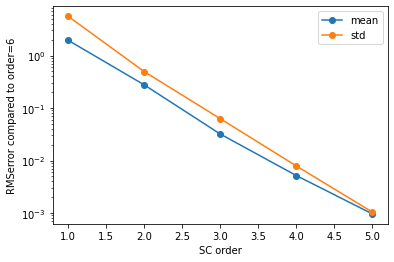

In [12]:
# plot the convergence of the mean and standard deviation to that of the highest order

if __name__ == '__main__':
    last = -1
    O = [R[r]['order'] for r in list(R.keys())]
    if len(O[0:last]) > 0:
        plt.figure()
        plt.semilogy([o for o in O[0:last]],
                     [np.sqrt(np.mean((R[o]['results'].describe('te', 'mean') - 
                                       R[O[last]]['results'].describe('te', 'mean'))**2)) for o in O[0:last]],
                     'o-', label='mean')
        plt.semilogy([o for o in O[0:last]],
                     [np.sqrt(np.mean((R[o]['results'].describe('te', 'std') - 
                                       R[O[last]]['results'].describe('te', 'std'))**2)) for o in O[0:last]],
                     'o-', label='std')
        plt.xlabel('SC order')
        plt.ylabel('RMSerror compared to order=%s' % (O[last]))
        plt.legend(loc=0)
        plt.savefig('Convergence_mean_std.png')
        plt.savefig('Convergence_mean_std.pdf')

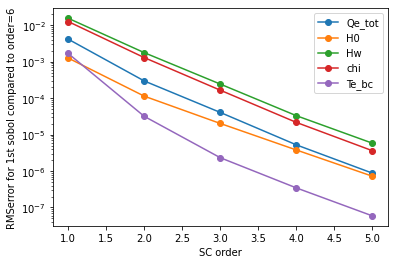

In [13]:
# plot the convergence of the first sobol to that of the highest order

if __name__ == '__main__':
    last = -1
    O = [R[r]['order'] for r in list(R.keys())]
    if len(O[0:last]) > 0:
        plt.figure()
        O = [R[r]['order'] for r in list(R.keys())]
        for v in list(R[O[last]]['results'].sobols_first('te').keys()):
            plt.semilogy([o for o in O[0:last]],
                         [np.sqrt(np.mean((R[o]['results'].sobols_first('te')[v] - 
                                           R[O[last]]['results'].sobols_first('te')[v])**2)) for o in O[0:last]],
                         'o-',
                         label=v)
        plt.xlabel('SC order')
        plt.ylabel('RMSerror for 1st sobol compared to order=%s' % (O[last]))
        plt.legend(loc=0)
        plt.savefig('Convergence_sobol_first.png')
        plt.savefig('Convergence_sobol_first.pdf')

Problem with some of the percentiles
Problem with some of the percentiles
Problem with sobols_second
Problem with sobols_total
Problem with distribution
Problem with sobols_second
Problem with sobols_total


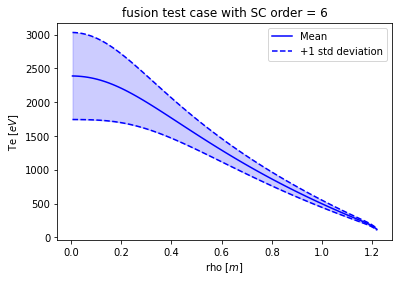

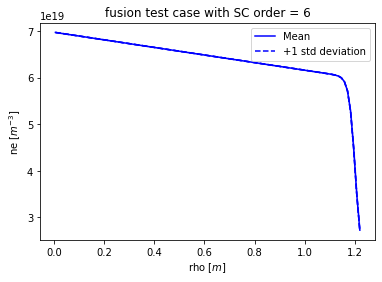

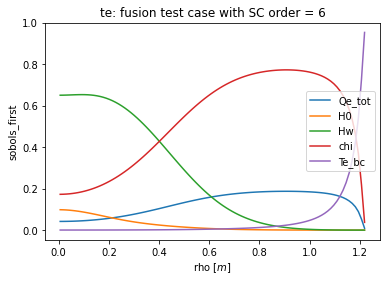

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

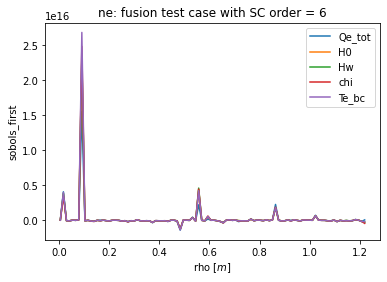

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [14]:
# plot a standard set of graphs for the highest order case

if __name__ == '__main__':
    last = -1
    title = 'fusion test case with SC order = %i' % list(R.values())[last]['order']
    plot_Te(list(R.values())[last]['results'], title=title,)
    plot_ne(list(R.values())[last]['results'], title=title)
    plot_sobols_first(list(R.values())[last]['results'], title=title)
    try:
        plot_sobols_second(list(R.values())[last]['results'], title=title)
    except:
        print('Problem with sobols_second')
    try:
        plot_sobols_total(list(R.values())[last]['results'], title=title)
    except:
        print('Problem with sobols_total')
    try:
        plot_distribution(list(R.values())[last]['results'], list(R.values())[last]['results_df'], title=title)
    except:
        print('Problem with distribution')
    plot_sobols_first(list(R.values())[last]['results'], title=title, field='ne')
    try:
        plot_sobols_second(list(R.values())[last]['results'], title=title, field='ne')
    except:
        print('Problem with sobols_second')
    try:
        plot_sobols_total(list(R.values())[last]['results'], title=title, field='ne')
    except:
        print('Problem with sobols_total')

In [15]:
RRR = list(R.values())[last]['results']

In [16]:
RRR.samples.describe().T

count         mean           std           min           25%  \
run_id    0   16807.0     8404.000  4.851907e+03  1.000000e+00  4.202500e+03   
iteration 0   16807.0        0.000  0.000000e+00  0.000000e+00  0.000000e+00   
Qe_tot    0   16807.0  2000000.000  1.358773e+05  1.810178e+06  1.851694e+06   
H0        0   16807.0        0.100  6.793864e-02  5.089209e-03  2.584688e-02   
Hw        0   16807.0        0.300  1.358773e-01  1.101784e-01  1.516938e-01   
...               ...          ...           ...           ...           ...   
rho_norm  95  16807.0        0.955  0.000000e+00  9.550000e-01  9.550000e-01   
          96  16807.0        0.965  0.000000e+00  9.650000e-01  9.650000e-01   
          97  16807.0        0.975  1.110256e-16  9.750000e-01  9.750000e-01   
          98  16807.0        0.985  3.330768e-16  9.850000e-01  9.850000e-01   
          99  16807.0        0.995  5.551280e-16  9.950000e-01  9.950000e-01   

                      50%           75%           max  
run_id    0      8404.000  1.260550e+04  1.680700e+04  
iteration 0         0.000  0.000000e+00  0.000000e+00  
Qe_tot    0   2000000.000  2.148306e+06  2.189822e+06  
H0        0         0.100  1.741531e-01  1.949108e-01  
Hw        0         0.300  4.483062e-01  4.898216e-01  
...                   ...           ...           ...  
rho_norm  95        0.955  9.550000e-01  9.550000e-01  
          96        0.965  9.650000e-01  9.650000e-01  
          97        0.975  9.750000e-01  9.750000e-01  
          98        0.985  9.850000e-01  9.850000e-01  
          99        0.995  9.950000e-01  9.950000e-01  

[417 rows x 8 columns]

In [17]:
# plot the convergence of the mean and standard deviation to that of the highest order
if __name__ == '__main__':
    _o = []
    _RMS = []
    for r in R.values():
        results_df = r['results_df']
        results = r['results']
        te_surrogate = np.squeeze(np.array(results.surrogate()(results_df[results.inputs])['te']), axis=2)
        te_samples = np.array(results_df['te']).T
        _RMS.append((np.sqrt((((te_surrogate - te_samples) / te_samples)**2).mean())))
        _o.append(r['order'])

    plt.figure()
    plt.semilogy(_o, _RMS, 'o-')
    plt.xlabel('PCE order')
    plt.ylabel('RMS error for the PCE surrogate')
    plt.legend(loc=0)
    #plt.savefig('Convergence_surrogate.png')
    #plt.savefig('Convergence_surrogate.pdf')

AxisError: axis 2 is out of bounds for array of dimension 1

In [19]:
(np.array(results.surrogate()(results_df[results.inputs])['te']))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])